# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

Resources

1. http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
2. http://scikit-learn.org/stable/modules/feature_extraction.html
3. http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
4. http://www.markhneedham.com/blog/2015/02/15/pythonscikit-learn-calculating-tfidf-on-how-i-met-your-mother-transcripts/
5. http://blog.christianperone.com/2011/09/machine-learning-text-feature-extraction-tf-idf-part-i/
6. http://www.cs.duke.edu/courses/spring14/compsci290/assignments/lab02.html

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

/Library/Python/2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Python/2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

# Combine training and test data to create a corpus
corpus_data = np.append(newsgroups_train.data,newsgroups_test.data)
corpus_labels = np.append(newsgroups_train.target,newsgroups_test.target)

print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', newsgroups_train.target_names
print 'corpus data shape:',corpus_data.shape
print 'corpus labels shape:',corpus_data.shape

# Initialize the set of all features from the corpus
vectorizer = CountVectorizer(min_df=1)
corpus_x = vectorizer.fit_transform(corpus_data)
all_feature_names = vectorizer.get_feature_names()


training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
corpus data shape: (3387,)
corpus labels shape: (3387,)


(1) For each of the first 5 training examples, print the text of the message along with the label.

[2 pts]

In [3]:
#def P1(num_examples=5):
### STUDENT START ###

# Displaying message and label for first five training examples
for i in range(0,5):
    print "Training Label"
    print "**************"
    print train_labels[i]

    print "Training Data"
    print "**************"
    print train_data[i]

### STUDENT END ###
#P1(2)

Training Label
**************
1
Training Data
**************
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
Training Label
**************
3
Training Data
**************


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

[6 pts]

In [4]:
#def P2():
### STUDENT START ###

from sklearn.feature_extraction.text import CountVectorizer

#(2) Use CountVectorizer to turn the raw training text into feature vectors. 
#You should use the fit_transform function, which makes 2 passes through the data: 
# first it computes the vocabulary ("fit"), second it converts the raw text into 
#feature vectors using the vocabulary ("transform").

# initialize and fit a CountVectorizer to the training data
vectorizer = CountVectorizer(min_df=1)
train_x = vectorizer.fit_transform(train_data)

# get feature names
feature_names = vectorizer.get_feature_names()

# transform X into a matrix
train_x_ = train_x.toarray()

# set floating point precision and avoid suppressing smaller values
np.set_printoptions(suppress=False,precision=16)

#a. The output of the transform (also of fit_transform) is a sparse matrix: 
#http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. 
#What is the size of the vocabulary? What is the average number of non-zero features per example? 
#What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

print "The size of the vocabulary is:", len(vectorizer.vocabulary_)
print "The shape of the training data is",train_x.shape
print "The average of non-zero features is:", (train_x.nnz/train_x_.shape[0])
print "Fraction of entries in the matrix that are non-zero is:", float(train_x.nnz)/float((train_x.shape[0]*train_x.shape[1]))

#b. What are the 0th and last feature strings (in alphabetical order)? 
#Hint: use the vectorizer's get_feature_names function.
print "The first feature string is:", feature_names[0]
print "The last feature string is:", feature_names[len(feature_names)-1]

#c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. 
#Confirm the training vectors are appropriately shaped. Now what's the average number of 
#non-zero features per example?
#print len(vectorizer.vocabulary_)
vocab = ["atheism", "graphics", "space", "religion"]

# initialize and fit a CountVectorizer to the training data
vectorizer = CountVectorizer(min_df=1,vocabulary=vocab)
train_x = vectorizer.fit_transform(train_data)

# get feature names
feature_names = vectorizer.get_feature_names()

print "\nDisplaying information using the limited vocabulary\n"
print "The size of the vocabulary is:", len(vectorizer.vocabulary_)
print "The shape of the training data is",train_x.shape
print "The average of non-zero features is:", (train_x.nnz/train_x_.shape[0])
print "Fraction of entries in the matrix that are non-zero is:", float(train_x.nnz)/float((train_x.shape[0]*train_x.shape[1]))
print "The first feature string is:", feature_names[0]
print "The last feature string is:", feature_names[len(feature_names)-1]

#d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract 
#bigram and trigram character features. What size vocabulary does this yield?

## Using bigram character features
vectorizer = CountVectorizer(min_df=1,analyzer='char',ngram_range=(2,2))
train_x = vectorizer.fit_transform(train_data)

print "\nThe size of the vocabulary using bigram character features:", len(vectorizer.vocabulary_)

## Using trigram character features
vectorizer = CountVectorizer(min_df=1,analyzer='char',ngram_range=(3,3))
train_x = vectorizer.fit_transform(train_data)

print "\nThe size of the vocabulary using trigram character features:", len(vectorizer.vocabulary_)

#e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. 
# What size vocabulary does this yield?
vectorizer = CountVectorizer(min_df=10)
train_x = vectorizer.fit_transform(train_data)

print "\nThe size of the vocabulary using min_df less than 10:", len(vectorizer.vocabulary_)

#f. Using the standard CountVectorizer, what fraction of the words in the dev data are 
# missing from the vocabulary? Hint: build a vocabulary for both train and dev and look 
# at the size of the difference.

# Build vectorizer using train data
vectorizer = CountVectorizer(min_df=1)
train_x = vectorizer.fit_transform(train_data)
train_vocab_size = len(vectorizer.vocabulary_)
print "\nDisplaying information using training data\n"
print "The size of the vocabulary is:", len(vectorizer.vocabulary_)
print "The shape of the training data is",train_x.shape
print "The average of non-zero features is:", (train_x.nnz/train_x_.shape[0])

# Build vectorizer using dev data
vectorizer = CountVectorizer(min_df=1)
train_x = vectorizer.fit_transform(dev_data)
dev_vocab_size = len(vectorizer.vocabulary_)
print "\nDisplaying information using dev data\n"
print "The size of the vocabulary is:", len(vectorizer.vocabulary_)
print "The shape of the training data is",train_x.shape
print "The average of non-zero features is:", (train_x.nnz/train_x_.shape[0])

print "\nThe difference in size between the training data and dev data is:", (train_vocab_size-dev_vocab_size)

### STUDENT END ###
#P2()

The size of the vocabulary is: 26879
The shape of the training data is (2034, 26879)
The average of non-zero features is: 96
Fraction of entries in the matrix that are non-zero is: 0.00359782722696
The first feature string is: 00
The last feature string is: zyxel

Displaying information using the limited vocabulary

The size of the vocabulary is: 4
The shape of the training data is (2034, 4)
The average of non-zero features is: 0
Fraction of entries in the matrix that are non-zero is: 0.0671091445428
The first feature string is: atheism
The last feature string is: religion

The size of the vocabulary using bigram character features: 3291

The size of the vocabulary using trigram character features: 32187

The size of the vocabulary using min_df less than 10: 3064

Displaying information using training data

The size of the vocabulary is: 26879
The shape of the training data is (2034, 26879)
The average of non-zero features is: 96

Displaying information using dev data

The size of the 

(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

[4 pts]

In [5]:
#def P3():
### STUDENT START ###

## KNN classifier ##
vectorizer = CountVectorizer(min_df=1)

# build vectorizer on the corpus to ensure that complete vocab is obtained across training and dev data
X = vectorizer.fit_transform(corpus_data)
X_ = X.toarray()

# extract training data and dev data from corpus
knn_train_data = X_[0:len(train_data)]
knn_dev_data = X_[len(train_data):len(train_data)+len(dev_data)]

# create KNN classifier and fit to training data
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(knn_train_data,train_labels)

# Determine optimal value of K
k_values = {'n_neighbors': [1,2,4,6]}
knn.get_params().keys()
gscv = GridSearchCV(knn,k_values)
gscv.fit(knn_dev_data,dev_labels)
print "Best k value for KNN is ",gscv.best_params_

# Display more information for the best param
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(knn_train_data,train_labels)
prediction = knn.predict(knn_dev_data)
print '\nClasification report for k=1:\n\n', classification_report(dev_labels, prediction)
print "\nAccuracy is ", knn.score(knn_dev_data,dev_labels)

## MULTINOMIAL NAIVE BAYES MODEL ###

mnb = MultinomialNB()

alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}

# run a search for the best estimator alpha
gscv = GridSearchCV(mnb,alphas)
gscv.fit(knn_train_data,train_labels)

print "Best alpha value for Multinomial NB is ",gscv.best_params_

# Generating classification report with best value of alpha 0.01
mnb = MultinomialNB(alpha=0.01)
mnb.fit(knn_train_data,train_labels)
prediction = mnb.predict(knn_dev_data)
print '\nClasification report for Multinomial Naive Bayes:\n\n', classification_report(dev_labels, prediction)
print "\nAccuracy is ", mnb.score(knn_dev_data,dev_labels)

## LOGISTIC REGRESSION MODEL ##
param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
lr = LogisticRegression(penalty='l2')
gscv = GridSearchCV(lr,param_grid)
gscv.fit(knn_train_data,train_labels)

print "Best alpha value for Logistic Regression is ",gscv.best_params_

# Generating classification report with best value of C
lr = LogisticRegression(penalty='l2',C=0.1)
lr.fit(knn_train_data,train_labels)
prediction = lr.predict(knn_dev_data)
print '\nClasification report for Logistic Regression:\n\n', classification_report(dev_labels, prediction)
print "\nAccuracy is ", lr.score(knn_dev_data,dev_labels)

# print coeff for logistic regression
print "\n Weights for Logistic Regression are:", lr.coef_

#c. Logistic regression estimates a weight vector for each class, which you 
# can access with the coef_ attribute. Output the sum of the squared weight values for 
#each class for each setting of the C parameter. Briefly explain the relationship 
#between the sum and the value of C.
print "\n Relationship between C and sum of weights\n"
for c_value in param_grid.get('C'):

    lr = LogisticRegression(penalty='l2',C=float(c_value))
    lr.fit(knn_train_data,train_labels)
    
    print "C-Value:",c_value," and Sum of weight values:", np.sum(lr.coef_)
    

### STUDENT END ###
#P3()

Best k value for KNN is  {'n_neighbors': 1}

Clasification report for k=1:

             precision    recall  f1-score   support

          0       0.40      0.39      0.40       165
          1       0.51      0.35      0.41       185
          2       0.43      0.45      0.44       199
          3       0.25      0.35      0.30       127

avg / total       0.41      0.39      0.39       676


Accuracy is  0.390532544379
Best alpha value for Multinomial NB is  {'alpha': 0.01}

Clasification report for Multinomial Naive Bayes:

             precision    recall  f1-score   support

          0       0.67      0.72      0.69       165
          1       0.92      0.90      0.91       185
          2       0.81      0.89      0.85       199
          3       0.65      0.50      0.57       127

avg / total       0.78      0.78      0.78       676


Accuracy is  0.779585798817
Best alpha value for Logistic Regression is  {'C': 0.1}

Clasification report for Logistic Regression:

            

ANSWER:

a. Why doesn't nearest neighbors work well for this problem?

Nearest neighbor does not work well for this problem because it tends to overfit the test data since it is looking for exact matches. 

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

Naive Bayes is based primarily on joint probabilistic expectation that a given set of words will match a particular class. This model works well for textual data. In the case of logistic regression, we do something similar to KNN by trying to compute the Euclidean distances between words. By modeling words as continuous variables and using the Euclidean distance metric, we lose the ability to quantify the real distance between words. For example, the edit distance (levenshtein distance) or n-gram models may be better able to represent than modeling as continous variables. Logistic regression is however different from KNN in that we are able to introduce regularization in the model to avoid for the implicit overfitting introduced by modeling textual content as continous variables.

c. Logistic regression estimates a weight vector for each class, which you can access with the coef_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

C is the regularization parameter. Higher values of C correspond to greater regularization. This causes the weights associated with our features to decrease especially when feature density is high. This is why with increasing C values we find that the sum of weights decreases.



(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

[5 pts]

In [6]:
#def P4():
### STUDENT START ###

import pandas as pd
from IPython.display import display, HTML

## KNN classifier ##
vectorizer = CountVectorizer(min_df=1,ngram_range=(1,1))

# build vectorizer on the corpus to ensure that complete vocab is obtained across training and dev data
X = vectorizer.fit_transform(corpus_data)
X_ = X.toarray()

all_feature_names = vectorizer.get_feature_names()

# extract training data and dev data from corpus
knn_train_data = X_[0:len(train_data)]
knn_dev_data = X_[len(train_data):len(train_data)+len(dev_data)]

# Train a logistic regression model 
lr = LogisticRegression(penalty='l2',C=0.1)
lr.fit(knn_train_data,train_labels)
prediction = lr.predict(knn_dev_data)
print '\nClasification report for Logistic Regression:\n\n', classification_report(dev_labels, prediction)
print "\nAccuracy is ", lr.score(knn_dev_data,dev_labels)

# print coeff for logistic regression
print "\n Weights for Logistic Regression are:", lr.coef_

# Determine the features with the top weights
# labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
weights = lr.coef_
nzweights = np.nonzero(weights)
print "\n Number of non-zero weights:",np.size(nzweights[0])

atheism_top_idx  = np.argsort(-weights[0])[0:5]
graphics_top_idx = np.argsort(-weights[1])[0:5]
space_top_idx    = np.argsort(-weights[2])[0:5]
religion_top_idx = np.argsort(-weights[3])[0:5]

atheism_top_weights  = weights[0][atheism_top_idx]
graphics_top_weights = weights[1][graphics_top_idx]
space_top_weights    = weights[2][space_top_idx]
religion_top_weights = weights[3][religion_top_idx]

d = {'Atheism Features':np.array(all_feature_names)[atheism_top_idx],
     'Atheism Weights':atheism_top_weights,
     'Graphics Features':np.array(all_feature_names)[graphics_top_idx],
     'Graphics Weights':graphics_top_weights,
     'Space Features':np.array(all_feature_names)[space_top_idx],
     'Space Weights':space_top_weights,
     'Religion Features':np.array(all_feature_names)[religion_top_idx],
    'Religion Weights':religion_top_weights,}

print "\n Displaying top 5 features and weights for unigram features"
df = pd.DataFrame(data=d)
display(df)
HTML(df.to_html())

####################################################
## Repeating the experiment with bigram features ###
####################################################

vectorizer = CountVectorizer(ngram_range=(2,2),min_df=1)

# build vectorizer on the corpus to ensure that complete vocab is obtained across training and dev data
X = vectorizer.fit_transform(corpus_data)
X_ = X.toarray()

all_feature_names = vectorizer.get_feature_names()

# extract training data and dev data from corpus
knn_train_data = X_[0:len(train_data)]
knn_dev_data = X_[len(train_data):len(train_data)+len(dev_data)]

# Train a logistic regression model 
lr = LogisticRegression(penalty='l2',C=0.1)
lr.fit(knn_train_data,train_labels)
prediction = lr.predict(knn_dev_data)
print '\nClasification report for Logistic Regression:\n\n', classification_report(dev_labels, prediction)
print "\nAccuracy is ", lr.score(knn_dev_data,dev_labels)

# print coeff for logistic regression
print "\n Weights for Logistic Regression are:", lr.coef_

# Determine the features with the top weights
#labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
weights = lr.coef_

atheism_top_idx  = np.argsort(-weights[0])[0:5]
graphics_top_idx = np.argsort(-weights[1])[0:5]
space_top_idx    = np.argsort(-weights[2])[0:5]
religion_top_idx = np.argsort(-weights[3])[0:5]

atheism_top_weights  = weights[0][atheism_top_idx]
graphics_top_weights = weights[1][graphics_top_idx]
space_top_weights    = weights[2][space_top_idx]
religion_top_weights = weights[3][religion_top_idx]

d = {'Atheism Features':np.array(all_feature_names)[atheism_top_idx],
     'Atheism Weights':atheism_top_weights,
     'Graphics Features':np.array(all_feature_names)[graphics_top_idx],
     'Graphics Weights':graphics_top_weights,
     'Space Features':np.array(all_feature_names)[space_top_idx],
     'Space Weights':space_top_weights,
     'Religion Features':np.array(all_feature_names)[religion_top_idx],
    'Religion Weights':religion_top_weights,}

print "\n Displaying top 5 features and weights for bigram features"
df = pd.DataFrame(data=d)
HTML(df.to_html())

### STUDENT END ###
#P4()


Clasification report for Logistic Regression:

             precision    recall  f1-score   support

          0       0.63      0.56      0.59       165
          1       0.74      0.90      0.81       185
          2       0.78      0.78      0.78       199
          3       0.59      0.49      0.53       127

avg / total       0.70      0.70      0.70       676


Accuracy is  0.704142011834

 Weights for Logistic Regression are: [[ -4.9128968293718385e-02   5.1857913520438795e-02
   -7.6554261439548219e-05 ...,   0.0000000000000000e+00
    0.0000000000000000e+00  -6.7893958159165611e-05]
 [  7.2389755077842260e-02  -3.1100970958436243e-03
   -7.7093929358544987e-03 ...,   0.0000000000000000e+00
    0.0000000000000000e+00   9.2737577838006117e-03]
 [ -2.7249442351296012e-02  -6.2691896679923795e-02
    4.3992448571519085e-03 ...,   0.0000000000000000e+00
    0.0000000000000000e+00  -5.2093569710007235e-03]
 [ -4.6540631795369040e-02  -1.6085872593150835e-02
   -3.3780270600938011e-0

,Atheism Features,Atheism Weights,Graphics Features,Graphics Weights,Religion Features,Religion Weights,Space Features,Space Weights
0,atheism,0.495559,graphics,1.007475,christian,0.547604,space,1.258785
1,religion,0.493964,image,0.642095,christians,0.499495,orbit,0.597354
2,bobby,0.478096,file,0.641223,blood,0.433870,nasa,0.540887
3,atheists,0.461570,computer,0.558994,order,0.429105,launch,0.478966
4,islam,0.426261,3d,0.546999,fbi,0.422115,moon,0.403120



Clasification report for Logistic Regression:

             precision    recall  f1-score   support

          0       0.65      0.53      0.58       165
          1       0.58      0.83      0.68       185
          2       0.62      0.71      0.66       199
          3       0.73      0.28      0.40       127

avg / total       0.64      0.62      0.60       676


Accuracy is  0.616863905325

 Weights for Logistic Regression are: [[  0.0000000000000000e+00  -5.8989097168497969e-04
    0.0000000000000000e+00 ...,   0.0000000000000000e+00
   -1.6943419923746504e-03   3.6407539446827913e-07]
 [  0.0000000000000000e+00  -2.1996415804253818e-03
    0.0000000000000000e+00 ...,   0.0000000000000000e+00
    8.7342062749455364e-03  -8.8003345276467535e-09]
 [  0.0000000000000000e+00   4.3123545018046109e-03
    0.0000000000000000e+00 ...,   0.0000000000000000e+00
   -3.3529543822680150e-03   3.3181076266162656e-08]
 [  0.0000000000000000e+00  -1.4780772715871893e-03
    0.0000000000000000e+0

,Atheism Features,Atheism Weights,Graphics Features,Graphics Weights,Religion Features,Religion Weights,Space Features,Space Weights
0,cheers kent,0.314805,looking for,0.671226,cheers kent,0.329547,the moon,0.562889
1,in this,0.297924,in advance,0.525636,the fbi,0.320272,the space,0.524644
2,is not,0.296123,out there,0.463000,with you,0.273989,and such,0.370202
3,claim that,0.285118,is there,0.415801,the word,0.255377,sci space,0.367723
4,are you,0.277472,comp graphics,0.382664,jesus christ,0.245855,it was,0.328212


ANSWER:

Using bigrams shows some very interesting word pairs such as "space shuttle", "the bible" and so on. However, it also introduces some constraints to the order in which the text must match, which appears to reduce the overall accuracy of the model.

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

[4 pts]

In [7]:
#def P5():
### STUDENT START ###

from sklearn.feature_extraction.text import strip_accents_unicode
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer

#nltk.download()

cachedStopWords = stopwords.words("english")
stemmer = SnowballStemmer("english")

first_time = True

# DEBUG index = 0

def custom_preprocessor(s):
    global first_time
    global cachedStopWords
    global stemmer
    
    # DEBUG global index 
    # DEBUG index = index+1
    # DEBUG print "custom_preprocessor invocation count:",index
    
    p = s;
    
    # remove accents
    p = strip_accents_unicode(s)
    
    # convert to lower case
    p = p.lower()
    
    # replace sequences of numbers with a single token
    p = re.sub(r'[\d]+',' N_U_M ',p)
    
    # remove punctuations
    p = re.sub(r'[^\w\s]','',p)
    std_p = p
    
    # Remove stop words
    p = ' '.join([word for word in p.split() if word not in cachedStopWords])
    stop_p = p
    
    # Perform stemming
    temp = p.split()
    p = ' '.join([stemmer.stem(w) for w in temp])
    stem_p = p
    
    if first_time == True:
        print "\nOriginal Text:"
        print "----------------"
        print s
        
        print "\nStd Preprocessing - replacing number sequences, escape characters, lower case and punctuations:"
        print "-------------------------------------------------------------------------------------------------"
        print std_p
        
        print "\nProcessing stop words:"
        print "------------------------"
        print stop_p 

        print "\nStemming:"
        print "----------"        
        print stem_p
        
        first_time = False

    return p

## Improved Logistic Regression Classifier)
vectorizer = CountVectorizer(min_df=1,preprocessor=custom_preprocessor)

# build vectorizer on the corpus to ensure that complete vocab is obtained across training and dev data
X = vectorizer.fit_transform(corpus_data)
X_ = X.toarray()

# extract training data and dev data from corpus
knn_train_data = X_[0:len(train_data)]
knn_dev_data = X_[len(train_data):len(train_data)+len(dev_data)]

# Train a logistic regression model 
lr = LogisticRegression(penalty='l2',C=0.1)
lr.fit(knn_train_data,train_labels)
prediction = lr.predict(knn_dev_data)
print '\nClasification report for Logistic Regression using a customer preprocessor:\n\n', classification_report(dev_labels, prediction)
print "\nAccuracy is ", lr.score(knn_dev_data,dev_labels)

    
### STUDENT END ###
#P5()


Original Text:
----------------
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

Std Preprocessing - replacing number sequences, escape characters, lower case and punctuations:
-------------------------------------------------------------------------------------------------
hi

ive noticed that if you only save a model with all your mapping planes
positioned carefully to a  N_U_M ds file that when you reload it after restarting
 N_U_M

(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

[4 pts]


Clasification report for Logistic Regression:

             precision    recall  f1-score   support

          0       0.58      0.50      0.54       165
          1       0.66      0.85      0.74       185
          2       0.70      0.72      0.71       199
          3       0.56      0.39      0.46       127

avg / total       0.63      0.64      0.63       676


Accuracy is  0.64201183432

 Weights for Logistic Regression are: [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]

 Number of non-zero weights: 357

All non-zero L1 features:
[u'10' u'all' u'also' u'am' u'an' u'and' u'argument' u'atheism' u'atheists'
 u'be' u'been' u'being' u'bobby' u'but' u'can' u'christ' u'christian'
 u'christians' u'claim' u'could' u'data' u'did' u'does' u'don'
 u'enviroleague' u'evidence' u'exist' u'file' u'files' u'for' u'from'
 u'god' u'graphics' u'have' u'him' u'hudson' u'if' u'image' u'in' u'is'
 u'islam' u'islamic' u'

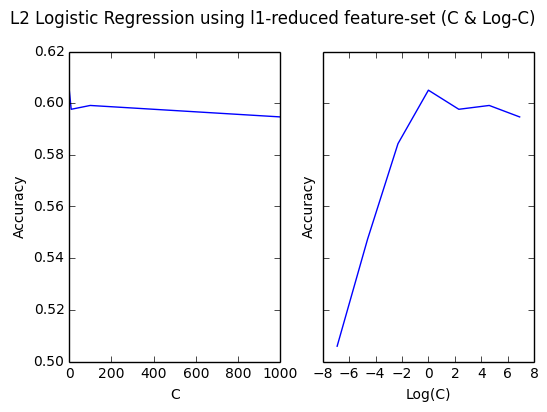

In [8]:
#def P6():
    ### STUDENT START ###
    
import numpy as np
import matplotlib.pyplot as plt

L1_features = []
first_time = True

# return only words that have non-zero weights when using L1 penalty
def custom_preprocessor(s):
    global first_time
    
    p = ' '.join([word for word in s.split() if word in L1_features])
    
    if first_time == True:
        print "\nOriginal Text:"
        print "----------------"
        print s
        
        print "\nKeep L1 non-zero weighted features:"
        print "-------------------------------------"
        print p
        
        first_time = False
    
    return p

    # Reduce the size of vocabulary to features that have at least one weight

# Keep this random seed here to make comparison easier.
np.random.seed(0)

### STUDENT START ###

# Get non-zero weights
vectorizer = CountVectorizer(min_df=1)
corpus_x = vectorizer.fit_transform(corpus_data)
all_feature_names = vectorizer.get_feature_names()

# build vectorizer on the corpus to ensure that complete vocab is obtained across training and dev data
X = vectorizer.fit_transform(corpus_data)
X_ = X.toarray()

# extract training data and dev data from corpus
knn_train_data = X_[0:len(train_data)]
knn_dev_data = X_[len(train_data):len(train_data)+len(dev_data)]

# Train a logistic regression model 
lr = LogisticRegression(penalty='l1',C=0.1)
lr.fit(knn_train_data,train_labels)
prediction = lr.predict(knn_dev_data)
print '\nClasification report for Logistic Regression:\n\n', classification_report(dev_labels, prediction)
print "\nAccuracy is ", lr.score(knn_dev_data,dev_labels)

# print coeff for logistic regression
print "\n Weights for Logistic Regression are:", lr.coef_
    
# print number of weights that are not equal to zero
weights = lr.coef_
nzweights = np.nonzero(weights)
print "\n Number of non-zero weights:",np.size(nzweights[0])
    
# Determine the features with the top weights
# labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
weights = lr.coef_
    
atheism_nz_idx  = np.array(nzweights[1])[np.where(nzweights[0]==0)]
graphics_nz_idx = np.array(nzweights[1])[np.where(nzweights[0]==1)]
space_nz_idx    = np.array(nzweights[1])[np.where(nzweights[0]==2)]
religion_nz_idx = np.array(nzweights[1])[np.where(nzweights[0]==3)]

atheism_l1_features  =  np.array(all_feature_names)[atheism_nz_idx]
graphics_l1_features =  np.array(all_feature_names)[graphics_nz_idx]
space_l1_features    =  np.array(all_feature_names)[space_nz_idx]
religion_l1_features =  np.array(all_feature_names)[religion_nz_idx]

L1_features = np.append(atheism_l1_features,atheism_l1_features,axis=0)
L1_features = np.append(L1_features,graphics_l1_features,axis=0)
L1_features = np.append(L1_features,space_l1_features,axis=0)
L1_features = np.append(L1_features,religion_l1_features,axis=0)

print "\nAll non-zero L1 features:\n", L1_features

# redo with non-zero L1 weighted features

vectorizer = CountVectorizer(min_df=1,preprocessor=custom_preprocessor)
corpus_x = vectorizer.fit_transform(corpus_data)
all_feature_names = vectorizer.get_feature_names()

# build vectorizer on the corpus to ensure that complete vocab is obtained across training and dev data
X = vectorizer.fit_transform(corpus_data)
X_ = X.toarray()

# extract training data and dev data from corpus
knn_train_data = X_[0:len(train_data)]
knn_dev_data = X_[len(train_data):len(train_data)+len(dev_data)]

# Train a logistic regression model 
lr = LogisticRegression(penalty='l2',C=0.1)
lr.fit(knn_train_data,train_labels)
prediction = lr.predict(knn_dev_data)
print '\nClasification report for Logistic Regression:\n\n', classification_report(dev_labels, prediction)
print "\nAccuracy is ", lr.score(knn_dev_data,dev_labels)

# Plotting accuracy for different values of C (regularization parameter)
## LOGISTIC REGRESSION MODEL ##
c_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
accuracy = []
for c_value in c_values:
    # Train a logistic regression model 
    lr = LogisticRegression(penalty='l2',C=c_value,tol=0.0001)
    lr.fit(knn_train_data,train_labels)
    accuracy.append(lr.score(knn_dev_data,dev_labels))

# plot accuracy vs C-value
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

plt.title('L2 Logistic Regression using l1-reduced feature-set (C & Log-C) \n',loc='right')

ax1.plot(c_values,accuracy)
ax1.set_xlabel('C')
ax1.set_ylabel('Accuracy')

ax2.set_xlabel('Log(C)')
ax2.set_ylabel('Accuracy')
ax2.plot(np.log(c_values),accuracy)

plt.show()

### STUDENT END ###
    
#P7()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

[4 pts]

In [9]:
#def P7():
    ### STUDENT START ###

from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

vectorizer = TfidfVectorizer(min_df=1)

# build vectorizer on the corpus to ensure that complete vocab is obtained across training and dev data
X = vectorizer.fit_transform(corpus_data)
X_ = X.toarray()

# extract training data and dev data from corpus
knn_train_data = X_[0:len(train_data)]
knn_dev_data = X_[len(train_data):len(train_data)+len(dev_data)]

# Train a logistic regression model 
lr = LogisticRegression(penalty='l2',C=100)
lr.fit(knn_train_data,train_labels)
prediction = lr.predict(knn_dev_data)
prediction_probs = lr.predict_proba(knn_dev_data)
print '\nClasification report for Logistic Regression:\n\n', classification_report(dev_labels, prediction)

score =  lr.score(knn_dev_data,dev_labels)
print "\nAccuracy is ", score

# Computing R ratio
r_ratio = np.zeros(shape=(676,4))
for i in range(0,len(dev_labels)):
#for i in range(0,3):
    correct_label_idx   = dev_labels[i]
    predicted_label_idx = np.argmax(prediction_probs[i])
    
    # set the dev_label index and the ratio
    r_ratio[i,0] = i
    r_ratio[i,1] = correct_label_idx
    r_ratio[i,2] = predicted_label_idx
    r_ratio[i,3] = prediction_probs[i,predicted_label_idx]/prediction_probs[i,correct_label_idx]
    
# Sort by R ratio
r_ratio_pd = pd.DataFrame(r_ratio).sort_values([3,2,1,0],ascending=[False,False,False,False])
r_ratio_pd.columns = ('Test Data Index','Correct Label','Predicted Label','Predicted Probability')
print r_ratio_pd[0:3]

# print the top 3 documents
for  i in range(0,3):
    print "\n"
    label_idx = r_ratio_pd.as_matrix()[i,1]
    
    #print "Correct Label:", r_ratio_pd.as_matrix()[i,2]
    #print "Predicted Label:", r_ratio_pd.as_matrix()[i,2]
    print "Correct Label Name:", newsgroups_train.target_names[int(r_ratio_pd.as_matrix()[i,1])]
    print "Predicted Label Name:", newsgroups_train.target_names[int(r_ratio_pd.as_matrix()[i,2])]
    print "R ratio:", r_ratio_pd.as_matrix()[i,3] 
    print "Document:\n",dev_data[int(r_ratio_pd.as_matrix()[i,0])]

    ### STUDENT END ###
#P7()


Clasification report for Logistic Regression:

             precision    recall  f1-score   support

          0       0.70      0.61      0.65       165
          1       0.80      0.90      0.85       185
          2       0.82      0.83      0.83       199
          3       0.68      0.65      0.66       127

avg / total       0.76      0.76      0.76       676


Accuracy is  0.761834319527
     Test Data Index  Correct Label  Predicted Label  Predicted Probability
215            215.0            3.0              1.0             545.990141
665            665.0            3.0              1.0             333.594775
655            655.0            3.0              0.0             180.643952


Correct Label Name: talk.religion.misc
Predicted Label Name: comp.graphics
R ratio: 545.990140828
Document:
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see

ANSWER:

The more eggregious misclassification appear to be a difficulty differentiating between (1) graphics and religion/atheism and (2) religion and atheism. While the difficulty to differentiate between religion and atheism is understandable, differentiating between graphics and religion/atheism should be more straightforward.

One way to try to improve our predictions is to focus on finding additional stop words by lowering the max document frequency for stop words. This allows us to remove words that appear too frequently. This can be done by reducing the max_df value and re-running the experiment.

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

- [1 pt] for a reasonable attempt
- [2 pts] for improved performance

In [10]:
vectorizer = TfidfVectorizer(min_df=1,max_df=0.79)

# build vectorizer on the corpus to ensure that complete vocab is obtained across training and dev data
X = vectorizer.fit_transform(corpus_data)
X_ = X.toarray()

# extract training data and dev data from corpus
knn_train_data = X_[0:len(train_data)]
knn_dev_data = X_[len(train_data):len(train_data)+len(dev_data)]

# Train a logistic regression model 
# Decreasing max_df and re-running the model
lr = LogisticRegression(penalty='l2',C=100)
lr.fit(knn_train_data,train_labels)
prediction = lr.predict(knn_dev_data)
prediction_probs = lr.predict_proba(knn_dev_data)
print '\nClasification report for Logistic Regression:\n\n', classification_report(dev_labels, prediction)

score =  lr.score(knn_dev_data,dev_labels)
print "\nAccuracy is ", score


Clasification report for Logistic Regression:

             precision    recall  f1-score   support

          0       0.70      0.62      0.66       165
          1       0.88      0.89      0.89       185
          2       0.78      0.87      0.83       199
          3       0.68      0.65      0.66       127

avg / total       0.77      0.77      0.77       676


Accuracy is  0.773668639053


ANSWER: (Bonus Question)
    
As expected, decreasing max_df increases our accuracy by close to 1.5 percentage points. Note however 
that the correct max_df value needs to be experimentally determined and would likely depend on the
domain. For this particular data set, a max_df between 0.7 and 0.8 appears to work.